<a href="https://colab.research.google.com/github/wu2ming/Song-Classification/blob/main/song_classification_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Dataset from Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
dataset_path = '/content/drive/My Drive/Wally/Training/Data/genres_original'

In [6]:
import os
import random
import numpy as np

SEED = 1

random.seed(SEED)
np.random.seed(SEED)

#Covert original data into trainable data

Turn .wav into melspectrogram used for Training

In [7]:
import os
import librosa

# get the list of all files and directories in the specified directory
def listdir(path: os.PathLike[str]) -> list[str]:
    """os.listdir with ".DS_Store" removed

    :param path: a str, bytes, or a path-like object
    :return: a list containing the names of the files in the directory.
    """
    ls = os.listdir(path)
    try:
        ls.remove(".DS_Store")
    except ValueError as e:
        pass
    return ls


# convert audio into melspectrogram and store
def load_song(song_folder):
  #zipped togther
  melspecs = []
  genres = []
  genre_to_id = {} #maps genre to its ID
  id_to_genre = [] #gets genre with specific ID

  for genre in listdir(song_folder):

    genre_folder = os.path.join(song_folder, genre)

    genre_to_id[genre] = len(id_to_genre)
    id_to_genre.append(genre)
    for song in listdir(genre_folder):
      if song.endswith(".wav"):
        #covert to melspec then to logmelpspec

        signal, sr = librosa.load(os.path.join(song_folder, genre, song))
        melspec = librosa.feature.melspectrogram(y=signal, sr=sr).T[:1280, ]
        #store in data structure
        melspecs.append(melspec)
        genres.append(genre_to_id[genre]) #store corresponding genre ID

  return melspecs, genres, genre_to_id, id_to_genre



In [8]:
melspecs, genres, genre_to_id, id_to_genre = load_song(dataset_path);

Plot Melspecturm

In [9]:
import matplotlib.pyplot as plt

#figure setting
plt.rcParams["figure.figsize"] = (12, 8)

In [10]:
print(len(genres))

999


In [11]:
print(type(melspecs[0]))

<class 'numpy.ndarray'>


In [12]:
#show n number of melspecturm for a genre
def plot_melspectrogram(genre_name, num):
  if(num <= 0): return;
  specs = []; #create new spec array for ploting

  #append valid melspecturm
  for spec, idx in zip(melspecs, genres):
    if id_to_genre[idx] == genre_name or id_to_genre[idx] == genre_name.lower():
      specs.append(spec);
      if len(specs) >= num:
        break;
  if len(specs) == 0:
    raise ValueError("No specs found");
  x = np.concatenate(specs, axis=1)
  x = (x - x.min()) / (x.max() - x.min())
  plt.imshow((x * 20).clip(0, 1.0))



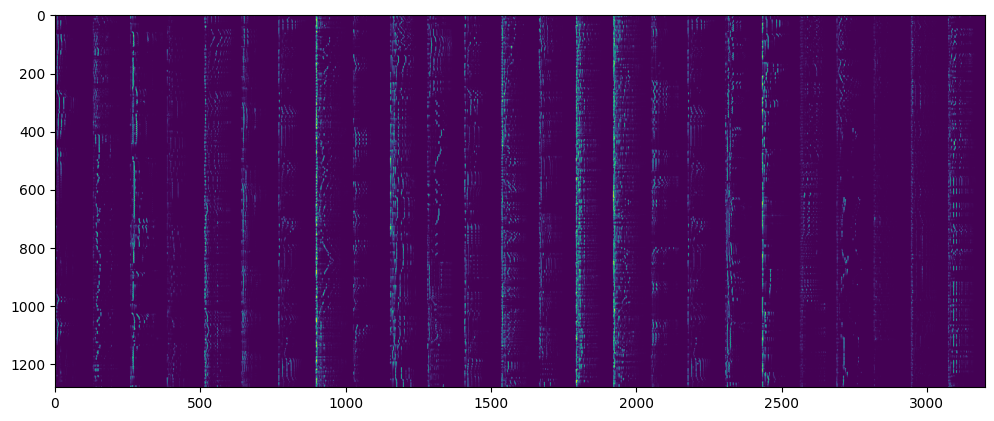

In [13]:
plot_melspectrogram("jazz", 25)

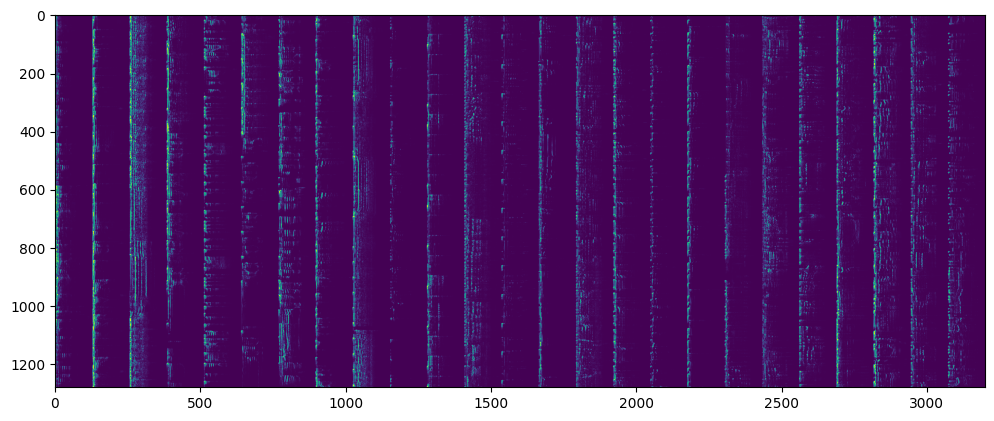

In [14]:
plot_melspectrogram("rock", 25)

#Train a Classification Network



Normalize Input

In [15]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import math
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# splits 1 element into 10
def split_10(x, y):
    s = x.shape
    s = (s[0] * 10, s[1] // 10, s[2])
    return x.reshape(s), np.repeat(y, 10, axis=0)

#one hot encode corresponding labels
genres_one_hot = np.eye(len(genre_to_id))[genres]


In [17]:
genres_one_hot[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
from sklearn.model_selection import train_test_split

#split train and test
x_train, x_test, y_train, y_test = train_test_split(np.array(melspecs), np.array(genres_one_hot), test_size=0.1)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.15)

#shuffles and split data into test and train data
input_train, class_train = split_10(x_train, y_train)
input_test, class_test = split_10(x_test, y_test)
input_validate, class_validate = split_10(x_validation, y_validation)

input_train.shape, input_test.shape, input_validate.shape

((7640, 128, 128), (1000, 128, 128), (1350, 128, 128))

In [31]:
input_train[3].shape
#melspecs have 1 color channel
# 128x128x1

(128, 128)

In [32]:
#training parameters
learning_rate = 0.02
batch_size = 64
num_epochs = 64

# Convert NumPy arrays to PyTorch tensors
input_train_tensor = torch.tensor(input_train, dtype=torch.float32).unsqueeze(1)
class_train_tensor = torch.tensor(class_train, dtype=torch.float32)
input_test_tensor = torch.tensor(input_test, dtype=torch.float32).unsqueeze(1)
class_test_tensor = torch.tensor(class_test, dtype=torch.float32)
input_validate_tensor = torch.tensor(input_validate, dtype=torch.float32).unsqueeze(1)
class_validate_tensor = torch.tensor(class_validate, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(input_train_tensor, class_train_tensor)
test_dataset = TensorDataset(input_test_tensor, class_test_tensor)
validate_dataset = TensorDataset(input_validate_tensor, class_validate_tensor)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
len(train_loader)

120

In [34]:
for i, (specs, labels) in enumerate(train_loader):
  print(specs.shape)
  print(labels.shape)
  break

torch.Size([64, 1, 128, 128])
torch.Size([64, 10])


Build CNN Network

In [35]:
class ConvNet(nn.Module):
  #initialize model
  def __init__(self):
    #call superclass
    super(ConvNet, self).__init__()
    #add dropout for avoiding overfitting
    self.dropout = nn.Dropout(0.5)
    #convolution block
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels = 128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=4)
    )
    #fully-connected layer
    self.fc1 = nn.Linear(256*8*8, 2048)
    self.GruLayer = nn.GRU(input_size=2048,
                        hidden_size=256,
                        num_layers=1,
                        batch_first=True,
                        bidirectional=False)

    self.GruLayerF = nn.Sequential(nn.BatchNorm1d(2048),
                                       nn.Dropout(0.6))

    self.fcBlock1 = nn.Sequential(nn.Linear(in_features=2048, out_features=512),
                                  nn.ReLU(),
                                  nn.Dropout(0.5))

    self.fcBlock2 = nn.Sequential(nn.Linear(in_features=512, out_features=256),
                                  nn.ReLU(),
                                  nn.Dropout(0.5))

    self.output = nn.Sequential(nn.Linear(in_features=256, out_features=10))

  #forward
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    #flatten Tensor
    x = x.contiguous().view(x.size()[0],x.size()[2] , -1)
    x, _ = self.GruLayer(x)
    x = x.contiguous().view(x.size()[0],  -1)
    # out_features=4096
    x = self.GruLayerF(x)
    x = self.fcBlock1(x)
    x = self.fcBlock2(x)
    x = self.output(x)
    return x


In [36]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [37]:
model = ConvNet().to(device)

#loss function and optimizer setup
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Define function for training and dealing with overfitting

In [38]:
#define early stop to avoid overfitting
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [39]:
def train_one_epoch(model, train_loader, optimizer, loss_function):
  model.train()
  running_loss = 0.0
  correct = 0
  samples = 0
  for i, (specs, labels) in enumerate(train_loader):
      specs = specs.to(device)
      labels = labels.to(device)
      # Forward pass
      outputs = model(specs)
      loss = loss_function(outputs, labels)
      # Backward and optimize
      optimizer.zero_grad() #clear gradients
      loss.backward() #compute gradient for loss
      optimizer.step() #update weights

      # Update running loss
      running_loss += loss.item()
      # Calculate accuracy
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels.max(1)[1]).sum().item()
      samples += labels.size(0)

  # Calculate average loss and accuracy for the epoch
  avg_loss = running_loss / len(train_loader)
  accuracy = correct / samples
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
  return avg_loss, accuracy

In [28]:
def validate_one_epoch(model, validation_loader, loss_function):
  model.eval()
  with torch.no_grad():
    running_loss = 0.0
    correct = 0
    samples = 0
    for i, (specs, labels) in enumerate(validation_loader):
        specs = specs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(specs)
        loss = loss_function(outputs, labels)

        # Update running loss
        running_loss += loss.item()
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels.max(1)[1]).sum().item()
        samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = running_loss / len(validation_loader)
    accuracy = correct / samples
    print(f"Validating [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

In [29]:
def plot_history(train_loss, train_accuracy, validate_loss, validate_accuracy):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(train_accuracy, label="train accuracy")
    axs[0].plot(validate_accuracy, label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(train_loss, label="train error")
    axs[1].plot(validate_loss, label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [40]:
#iterate through every epoch
iters_per_epoch = len(train_loader)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.5)
#record loss and accuracy for plotting
train_loss = []
train_accuracy = []
validate_loss = []
validate_accuracy = []
for epoch in range(num_epochs):
    epoch_train_loss, epoch_train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_function)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    epoch_validate_loss, epoch_validate_accuracy = validate_one_epoch(model, validation_loader, loss_function)
    validate_loss.append(epoch_validate_loss)
    validate_accuracy.append(epoch_validate_accuracy)

    # early stopping
    early_stopping(epoch_train_loss, epoch_validate_loss)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch+1)
      break



Epoch [1/64], Loss: 2.1090, Accuracy: 0.2096
Validating [1/64], Loss: 1.9530, Accuracy: 0.2311
Epoch [2/64], Loss: 1.9460, Accuracy: 0.2801
Validating [2/64], Loss: 1.8453, Accuracy: 0.2948
Epoch [3/64], Loss: 1.8309, Accuracy: 0.3229
Validating [3/64], Loss: 1.7829, Accuracy: 0.3096
Epoch [4/64], Loss: 1.7211, Accuracy: 0.3606
Validating [4/64], Loss: 1.7370, Accuracy: 0.3496
Epoch [5/64], Loss: 1.6318, Accuracy: 0.3927
Validating [5/64], Loss: 1.7285, Accuracy: 0.3607
Epoch [6/64], Loss: 1.5488, Accuracy: 0.4339
Validating [6/64], Loss: 1.6650, Accuracy: 0.3830
Epoch [7/64], Loss: 1.4656, Accuracy: 0.4630
Validating [7/64], Loss: 1.4637, Accuracy: 0.4800
Epoch [8/64], Loss: 1.4045, Accuracy: 0.4929
Validating [8/64], Loss: 1.4475, Accuracy: 0.4719
Epoch [9/64], Loss: 1.3377, Accuracy: 0.5141
Validating [9/64], Loss: 1.7316, Accuracy: 0.3874
Epoch [10/64], Loss: 1.2693, Accuracy: 0.5488
Validating [10/64], Loss: 1.5267, Accuracy: 0.4785
Epoch [11/64], Loss: 1.2033, Accuracy: 0.5737
Va

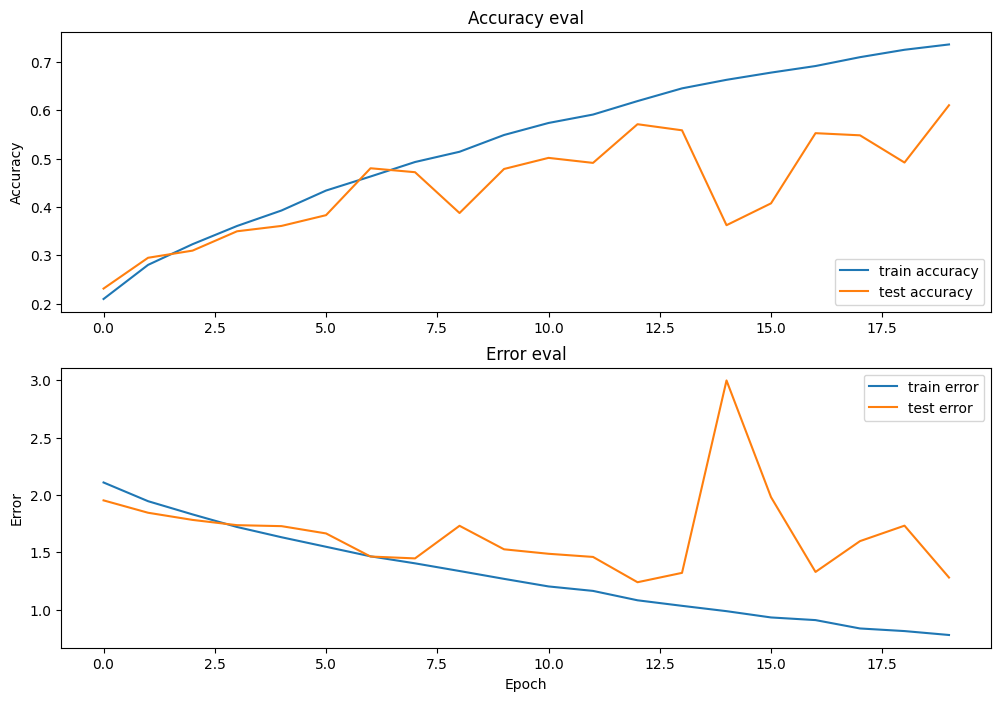

In [41]:
#show plot
plot_history(train_loss, train_accuracy, validate_loss, validate_accuracy)

In [ ]:
print('Finished Training')
#save model
PATH = './cnn_v2.pth'
torch.save(model.state_dict(), PATH)

# Testing

Test on 3s audio

In [42]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for specs, labels in test_loader:
        specs = specs.to(device)
        labels = labels.to(device)
        outputs = model(specs)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels.max(1)[1]).sum().item()

        for i in range(len(labels)):
            label = labels.max(1)[1][i]
            predict = predicted[i]
            if (label == predict):
              n_class_correct[label] +=1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    for i in range(10):
        acc =  100.0 * n_class_correct[i] / n_class_samples[i] if n_class_samples[i] !=0 else 0;
        print(f'Accuracy of {id_to_genre[i]}: {acc} %')

Accuracy of the network: 60.9 %
Accuracy of classical: 95.0 %
Accuracy of metal: 73.0 %
Accuracy of rock: 51.42857142857143 %
Accuracy of reggae: 57.5 %
Accuracy of pop: 50.0 %
Accuracy of country: 52.666666666666664 %
Accuracy of disco: 93.33333333333333 %
Accuracy of jazz: 42.72727272727273 %
Accuracy of hiphop: 45.0 %
Accuracy of blues: 53.75 %
